<a href="https://colab.research.google.com/github/waqasahmad-developer/Cow-Lumpy-Disease-Prediction/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/training-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import shutil
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import MobileNetV2

In [ ]:
os.makedirs('/content/dataset', exist_ok=True)

shutil.move('/content/healthycows', '/content/dataset/healthycows')
shutil.move('/content/lumpycows', '/content/dataset/lumpycows')

'/content/dataset/lumpycows/lumpycows'

In [ ]:
train_dir = '/content/dataset'

img_height, img_width = 256, 256
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)


Found 1498 images belonging to 2 classes.
Found 374 images belonging to 2 classes.


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/tmp/ipython-input-39-2664283645.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 720ms/step - accuracy: 0.6514 - loss: 0.6797 - val_accuracy: 0.8422 - val_loss: 0.4229
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 467ms/step - accuracy: 0.7650 - loss: 0.4950 - val_accuracy: 0.9171 - val_loss: 0.2936
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - accuracy: 0.7861 - loss: 0.4449 - val_accuracy: 0.9091 - val_loss: 0.2832
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 466ms/step - accuracy: 0.8413 - loss: 0.3844 - val_accuracy: 0.9037 - val_loss: 0.2879
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 468ms/step - accuracy: 0.8517 - loss: 0.3562 - val_accuracy: 0.9171 - val_loss: 0.2500


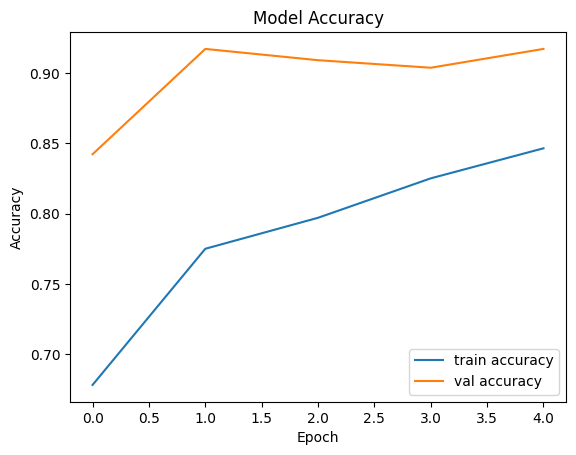

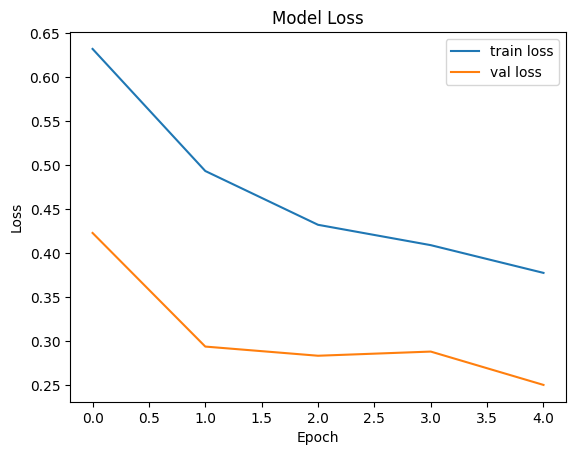

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
for layer in base_model.layers[:100]:
    layer.trainable = False

for layer in base_model.layers[100:]:
    layer.trainable = True



callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 95s 739ms/step - accuracy: 0.9854 - loss: 0.0460 - val_accuracy: 0.9492 - val_loss: 0.1368 - learning_rate: 1.0000e-05
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 497ms/step - accuracy: 0.9887 - loss: 0.0311 - val_accuracy: 0.9385 - val_loss: 0.1595 - learning_rate: 1.0000e-05
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 521ms/step - accuracy: 0.9889 - loss: 0.0366 - val_accuracy: 0.9412 - val_loss: 0.1551 - learning_rate: 1.0000e-05
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 480ms/step - accuracy: 0.9864 - loss: 0.0281 - val_accuracy: 0.9439 - val_loss: 0.1259 - learning_rate: 3.0000e-06
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 484ms/step - accuracy: 0.9869 - loss: 0.0329 - val_accuracy: 0.9626 - val_loss: 0.1053 - learning_rate: 3.0000e-06
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 508ms/step - accuracy: 0.9937 - loss: 0.0282 - val_accuracy: 0.9679 - val_loss: 0.0852 - learning_rate: 3.0000e-06
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 484ms/step - acc

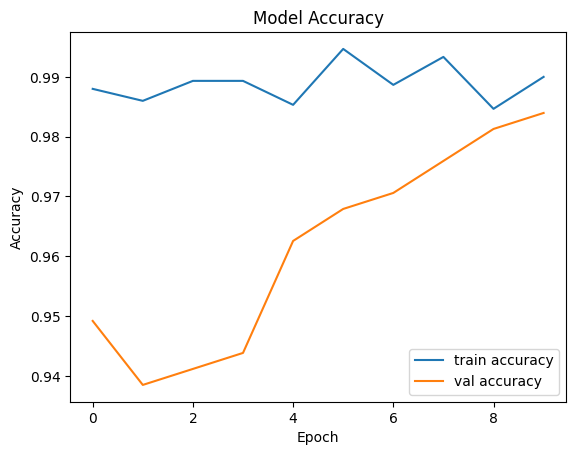

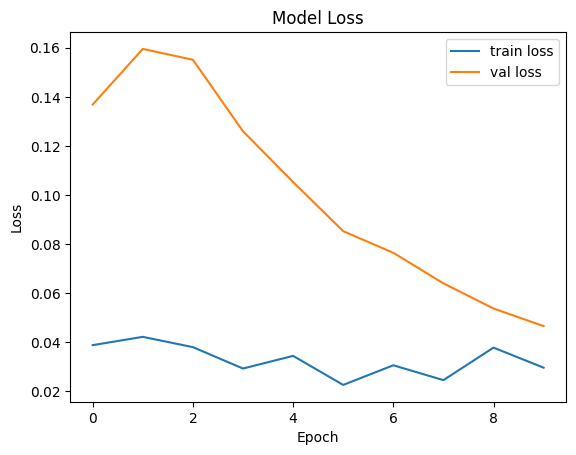

In [ ]:
# Accuracy
plt.plot(history_fine.history['accuracy'], label='train accuracy')
plt.plot(history_fine.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Loss
plt.plot(history_fine.history['loss'], label='train loss')
plt.plot(history_fine.history['val_loss'], label='val loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

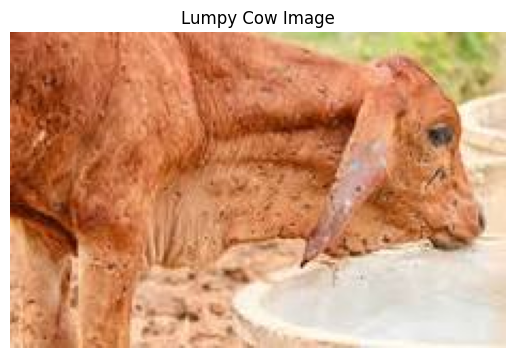

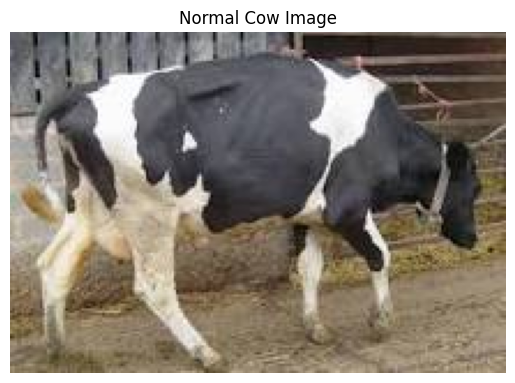

In [ ]:
img_path_lumpy = '/content/download.jpg'  # Lumpy Cow Image
img_path_normal = '/content/download (1).jpg' # Normal Cow Image

img_lumpy = image.load_img(img_path_lumpy)
img_normal = image.load_img(img_path_normal)

plt.imshow(img_lumpy)
plt.title('Lumpy Cow Image')
plt.axis('off')
plt.show()

plt.imshow(img_normal)
plt.title('Normal Cow Image')
plt.axis('off')
plt.show()

In [ ]:
img_path_normal = '/content/download (1).jpg' # Normal Cow Image

img_normal = image.load_img(img_path_normal, target_size=(img_height, img_width))

img_array_normal = image.img_to_array(img_normal)

img_array_normal = np.expand_dims(img_array_normal, axis=0) / 255.0

# Make prediction
prediction_normal = model.predict(img_array_normal)

if prediction_normal > 0.5:
    print(f"The cow in the normal image is predicted to have lumpy disease (confidence: {prediction_normal[0][0]:.4f})")
else:
    print(f"The cow in the normal image is predicted to be normal (confidence: {1 - prediction_normal[0][0]:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The cow in the normal image is predicted to be normal (confidence: 0.9620)


In [ ]:
img_path_lumpy = '/content/download.jpg'  # Lumpy Cow Image

img_lumpy = image.load_img(img_path_lumpy, target_size=(img_height, img_width))

img_array_lumpy = image.img_to_array(img_lumpy)

img_array_lumpy = np.expand_dims(img_array_lumpy, axis=0) / 255.0

# Make prediction
prediction_lumpy = model.predict(img_array_lumpy)

if prediction_lumpy > 0.5:
    print(f"The cow in the lumpy image is predicted to have lumpy disease (confidence: {prediction_lumpy[0][0]:.4f})")
else:
    print(f"The cow in the lumpy image is predicted to be normal (confidence: {1 - prediction_lumpy[0][0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The cow in the lumpy image is predicted to have lumpy disease (confidence: 0.9987)


In [ ]:
model.save("lumpy_cow_classifier_model.keras")

In [ ]:
zip_path = '/content/test.zip'
extract_dir = '/content/test'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

test_dir = os.path.join(extract_dir, 'test')


img_height, img_width = 256, 256
batch_size = 16

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


model = load_model('/content/lumpy_cow_classifier_model.keras')

predictions = model.predict(test_generator)
y_pred = np.round(predictions)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Found 54 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 62 variables whereas the saved optimizer has 122 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
Confusion Matrix:
[[26  2]
 [ 0 26]]

Classification Report:
              precision    recall  f1-score   support

healthy-cows       1.00      0.93      0.96        28
  lumpy-cows       0.93      1.00      0.96        26

    accuracy                           0.96        54
   macro avg       0.96      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54



In [ ]:
print("Class labels:", class_labels)

Class labels: ['healthy-cows', 'lumpy-cows']
